In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

# Load the dataset from Google Drive into a pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PhD_Thesis_Experiments/GitHub_ToChair/sample_complaints_2years_006_balanced.csv')

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Function to split hierarchical labels into product and sub-product
def split_hierarchical_label(label):
    if '::' in label:
        return label.split('::')
    else:
        return [label, 'None'] # Handle cases with no sub-product

# Function to calculate hierarchical metrics
def hierarchical_metrics(y_true, y_pred):
    product_true = [split_hierarchical_label(label)[0] for label in y_true]
    sub_product_true = [split_hierarchical_label(label)[1] for label in y_true]
    product_pred = [split_hierarchical_label(label)[0] for label in y_pred]
    sub_product_pred = [split_hierarchical_label(label)[1] for label in y_pred]

    # Calculate metrics at the product level
    product_precision = precision_score(product_true, product_pred, average='weighted', zero_division=0)
    product_recall = recall_score(product_true, product_pred, average='weighted', zero_division=0)
    product_f1 = f1_score(product_true, product_pred, average='weighted', zero_division=0)

    # Calculate metrics at the sub-product level (only for non-None sub-products)
    # We need to filter for cases where both true and predicted sub-products are not 'None'
    valid_sub_product_true = [sub for i, sub in enumerate(sub_product_true) if sub != 'None' and sub_product_pred[i] != 'None']
    valid_sub_product_pred = [sub for i, sub in enumerate(sub_product_pred) if sub != 'None' and sub_product_true[i] != 'None']


    sub_product_precision = precision_score(valid_sub_product_true, valid_sub_product_pred, average='weighted', zero_division=0) if valid_sub_product_true else 0
    sub_product_recall = recall_score(valid_sub_product_true, valid_sub_product_pred, average='weighted', zero_division=0) if valid_sub_product_true else 0
    sub_product_f1 = f1_score(valid_sub_product_true, valid_sub_product_pred, average='weighted', zero_division=0) if valid_sub_product_true else 0


    # A simple way to combine scores (can be weighted based on importance)
    # Here, we'll just average them
    hierarchical_precision = (product_precision + sub_product_precision) / 2
    hierarchical_recall = (product_recall + sub_product_recall) / 2
    hierarchical_f1 = (product_f1 + sub_product_f1) / 2

    return {
        'product_precision': product_precision,
        'product_recall': product_recall,
        'product_f1': product_f1,
        'sub_product_precision': sub_product_precision,
        'sub_product_recall': sub_product_recall,
        'sub_product_f1': sub_product_f1,
        'hierarchical_precision': hierarchical_precision,
        'hierarchical_recall': hierarchical_recall,
        'hierarchical_f1': hierarchical_f1
    }


In [6]:
df.dropna(subset=['consumer_complaint_narrative', 'hierarchical_label'], inplace=True)
df = df[df['consumer_complaint_narrative'].str.strip() != '']
print(f"Original Data size: {len(df)}")

# --- 2. Label Encoding ---
# The model needs numerical labels. We'll train on the full hierarchical label.
label_encoder = LabelEncoder()
df['label_id'] = label_encoder.fit_transform(df['hierarchical_label'])

# Store the mapping for decoding predictions later
id_to_label = {i: label for i, label in enumerate(label_encoder.classes_)}
num_labels = len(id_to_label)
print(f"Total unique classes (num_labels): {num_labels}")

Original Data size: 16000
Total unique classes (num_labels): 16


In [7]:
# --- 3. Split Data ---
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label_id'])
# Create Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
test_dataset = Dataset.from_pandas(test_df, preserve_index=False)

In [8]:
# --- 4. Tokenizer and Tokenization Function ---
# FinBERT model from Hugging Face for financial text classification (tone/sentiment is often a good base)
MODEL_NAME = "ProsusAI/finbert" # A general FinBERT model
MAX_LENGTH = 128

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    """Tokenizes the text column and prepares the 'label' for the model."""
    # BERT expects an 'input_ids', 'attention_mask'
    tokenized_text = tokenizer(
        examples["consumer_complaint_narrative"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH
    )
    # The model expects the label column to be named 'labels'
    tokenized_text["labels"] = examples["label_id"]
    return tokenized_text

# Apply tokenization
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Select and rename columns as required by the Trainer
tokenized_train_dataset.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])
tokenized_test_dataset.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])

print("\nData preprocessing complete.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/12800 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]


Data preprocessing complete.


In [12]:

# --- 1. Load Model with Mismatch Ignored ---
# Load the pre-trained FinBERT model and configure the final layer for our number of classes.
# The 'ignore_mismatched_sizes=True' flag tells the function to randomly initialize
# the final classification layer (the one causing the size mismatch) while loading
# the rest of the compatible BERT weights.
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    ignore_mismatched_sizes=True  # 👈 THIS IS THE FIX
)

print(f"Loaded FinBERT and initialized a new classification head for {num_labels} classes.")

# --- 2. Define Compute Metrics for Validation during Training (Standard Metrics) ---
# NOTE: We use standard sklearn metrics here for *internal* validation during training.
# The final hierarchical evaluation will happen *after* training on the test set.
def compute_metrics(eval_pred):
    """A standard metric function for the Hugging Face Trainer."""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Standard classification metrics on the numerical label_ids
    return {
        'accuracy': (predictions == labels).mean(),
        'f1_weighted': f1_score(labels, predictions, average='weighted', zero_division=0)
    }

# --- 3. Define Training Arguments ---
training_args = TrainingArguments(
    output_dir="./finbert_results",
    num_train_epochs=10,                     # Number of training epochs (can be tuned)
    per_device_train_batch_size=16,         # Batch size per device during training
    per_device_eval_batch_size=16,          # Batch size for evaluation
    warmup_steps=500,                       # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,                      # Strength of weight decay
    logging_dir='./logs',
    logging_steps=50,

    # FIX: Use 'eval_strategy' instead of 'evaluation_strategy'
    eval_strategy="epoch",                  # Evaluate at the end of each epoch

    save_strategy="epoch",                  # Save checkpoint at the end of each epoch
    load_best_model_at_end=True,            # Load the best model found during training
    metric_for_best_model="f1_weighted",
    fp16=torch.cuda.is_available()          # Use 16-bit precision if CUDA is available
)

# --- 4. Initialize and Train Trainer ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
)

print("\nStarting model fine-tuning...")
trainer.train()
print("\nModel fine-tuning complete.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([16, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([16]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded FinBERT and initialized a new classification head for 16 classes.

Starting model fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted
1,0.915800,0.808755,0.724688,0.719216
2,0.368000,0.308972,0.909062,0.909261
3,0.124300,0.211097,0.942813,0.942980
4,0.043200,0.175436,0.962187,0.962254
5,0.022600,0.167392,0.967500,0.967418
6,0.018200,0.128614,0.976250,0.976222
7,0.001100,0.112540,0.977812,0.977808
8,0.000200,0.097795,0.983437,0.983423
9,0.000100,0.099788,0.981250,0.981214
10,0.001900,0.090034,0.982500,0.982489



Model fine-tuning complete.


In [13]:
# Assuming 'model' is the variable holding your BertForSequenceClassification model

# Define a path and filename for your saved model
OUTPUT_MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/PhD_Thesis_Experiments/GitHub_ToChair/finbert_classifier_model_epoch10'

# Save the model's state dictionary
torch.save(model.state_dict(), OUTPUT_MODEL_PATH)

print(f"Model saved successfully to: {OUTPUT_MODEL_PATH}")


Model saved successfully to: /content/drive/MyDrive/Colab Notebooks/PhD_Thesis_Experiments/GitHub_ToChair/finbert_classifier_model_epoch10


In [14]:
# --- 1. Get Predictions on the Test Set ---
# The Trainer's predict method returns an object with predictions, label_ids, and metrics
predictions_output = trainer.predict(tokenized_test_dataset)

# Extract predicted numerical label IDs (argmax across the logits)
predicted_label_ids = np.argmax(predictions_output.predictions, axis=1)

# Extract true numerical label IDs
true_label_ids = predictions_output.label_ids

# --- 2. Decode Numerical IDs back to Hierarchical Strings ---
# The hierarchical_metrics function requires the original string labels
y_true_labels_str = [id_to_label[i] for i in true_label_ids]
y_pred_labels_str = [id_to_label[i] for i in predicted_label_ids]

# --- 3. Run Custom Hierarchical Evaluation ---
final_metrics = hierarchical_metrics(
    y_true=y_true_labels_str,
    y_pred=y_pred_labels_str
)

print("\n" + "="*50)
print("### FINAL HIERARCHICAL EVALUATION RESULTS ###")
print("="*50)
for k, v in final_metrics.items():
    print(f"✅ {k:<25}: {v:.4f}")
print("="*50)

# Optional: Print standard metrics (e.g., test accuracy)
print("\nStandard Test Metrics from Trainer:")
print(trainer.evaluate(tokenized_test_dataset))


### FINAL HIERARCHICAL EVALUATION RESULTS ###
✅ product_precision        : 0.9901
✅ product_recall           : 0.9900
✅ product_f1               : 0.9900
✅ sub_product_precision    : 0.9836
✅ sub_product_recall       : 0.9834
✅ sub_product_f1           : 0.9834
✅ hierarchical_precision   : 0.9868
✅ hierarchical_recall      : 0.9867
✅ hierarchical_f1          : 0.9867

Standard Test Metrics from Trainer:


{'eval_loss': 0.09779476374387741, 'eval_accuracy': 0.9834375, 'eval_f1_weighted': 0.9834231889036533, 'eval_runtime': 5.8897, 'eval_samples_per_second': 543.322, 'eval_steps_per_second': 33.958, 'epoch': 10.0}


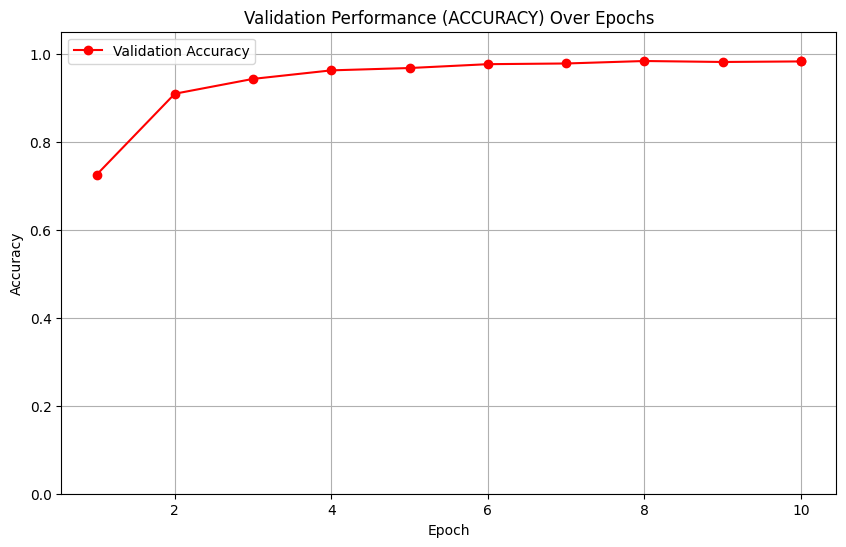

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'trainer' is your trained Hugging Face Trainer object
metrics_df = pd.DataFrame(trainer.state.log_history)

# --- 1. Identify Your Metric Key ---
# Check the columns in the DataFrame that start with 'eval_'.
# Since your model is for classification, it is likely 'eval_accuracy' or 'eval_f1_weighted'.
# You MUST replace 'eval_YOUR_METRIC_KEY' below with the correct name from your logs.

# Example: If your compute_metrics returned {'accuracy': 0.85}, the column is 'eval_accuracy'
METRIC_KEY = 'eval_accuracy' # <--- **Check your logs and use the correct key!**

# Filter to get evaluation metrics
eval_metrics = metrics_df[metrics_df[METRIC_KEY].notna()].copy()

# --- 2. Plotting the Validation Performance ---
plt.figure(figsize=(10, 6))

# Plot Validation Accuracy/F1
plt.plot(
    eval_metrics['epoch'],
    eval_metrics[METRIC_KEY],
    label=f'Validation {METRIC_KEY.split("_")[-1].title()}',
    color='red',
    marker='o'
)

plt.title(f'Validation Performance ({METRIC_KEY.split("_")[-1].upper()}) Over Epochs')
plt.xlabel('Epoch')
plt.ylabel(METRIC_KEY.split("_")[-1].title())
plt.grid(True)
plt.legend()
plt.ylim(0.0, 1.05)
plt.show()

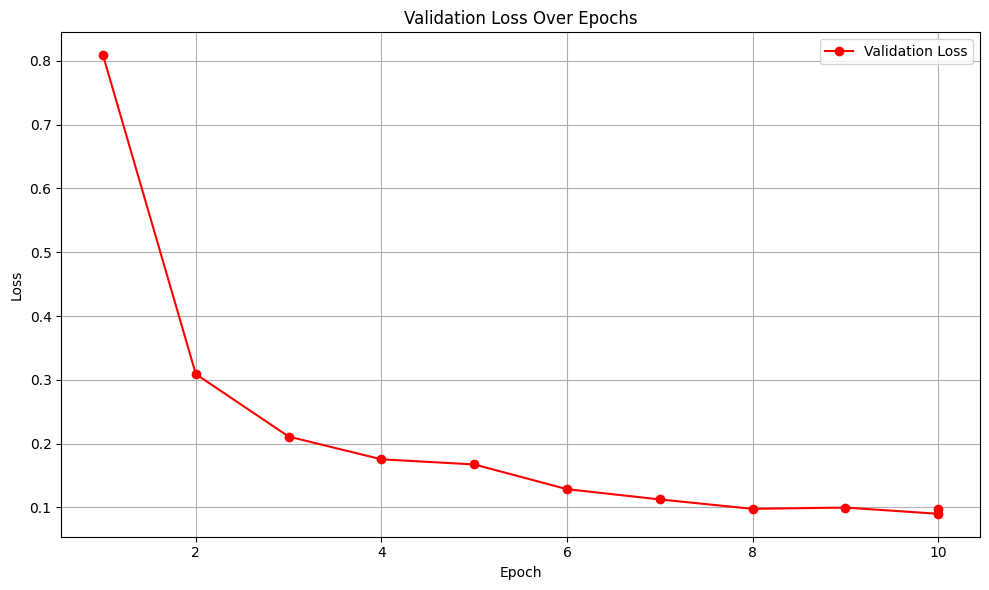

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'trainer' is your trained Hugging Face Trainer object
# The metrics_df is created from the log_history
metrics_df = pd.DataFrame(trainer.state.log_history)

# Filter the DataFrame to get only the rows with validation loss (logged per epoch)
validation_loss_df = metrics_df[metrics_df['eval_loss'].notna()].copy()

# Plot the Validation Loss
plt.figure(figsize=(10, 6))

# Plot Validation Loss against Epoch
plt.plot(
    validation_loss_df['epoch'],
    validation_loss_df['eval_loss'],
    label='Validation Loss',
    color='red',
    marker='o'
)

plt.title('Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save the plot
plt.savefig('validation_loss_plot.png')